# Contents
* [1 Imports and File Locations](#1)
* [2 Read Parcel file into dataframe](#2)
* [3 Property Site Address](#3)
* [4 Read Sales file into dataframe](#4)
* [5 Sales Date](#5)
* [6 Merge Sales and Parcel Data](#6)
* [7 PIN - Property Identification Number](#7)
* [8 DOR Code - Department of Revenue Code](#8)
* [9 NBHC - Neighborhood Code](#9)
* [10 VI - Vacant or Improved at time of sale](#10)
* [11 QU - Qualified or Unqualified](#11)
* [12 REA Code - Reason Code for Qualified or Unqualified](#12)
* [13 Sale Amount](#13)
* [14 Subdivision Code / Land Type ID](#14)
* [15 STR - Section Township Range](#15)
* [16 S_TYPE - legal instrument recorded at County Clerk's office](#16)
* [17 Municipality Code](#17)
* [18 SD1 & SD2 - Special Tax District](#18)
* [19 TIF - Tax increment fund](#19)
* [20 Property Attributes](#20)
* [21 Current Values of Property](#21)
* [22 Year Data](#22)
* [23 Final DataFrame](#23)

# 1 Imports and File Locations<a id='1'></a>

In [1]:
import pandas as pd
import numpy as np
import re
import datetime as dt
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
import pandas_profiling
from pandas_profiling.utils.cache import cache_file

In [2]:
ext_data = '../data/external/'
raw_data = '../data/raw/'
interim_data = '../data/interim/'
report_figures = '../reports/figures/'

# 2 Read Parcel file into dataframe<a id='2'></a>

In [3]:
parcel_df = pd.read_csv(raw_data + 'parcel_df.csv', dtype={'FOLIO': object, 'NBHC': object, 'ACT': object, 'EFF': object, 'BASE': object, 'SD1': str, 'SD2': str, 'TIF': str})

C:\Users\mkars\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
print(parcel_df.shape)
print(parcel_df.info())

(512207, 47)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512207 entries, 0 to 512206
Data columns (total 47 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   FOLIO      512206 non-null  object 
 1   TYPE       1 non-null       object 
 2   Edit_dt    512207 non-null  object 
 3   PIN        512179 non-null  object 
 4   DOR_C      512179 non-null  object 
 5   OWNER      512127 non-null  object 
 6   ADDR_1     511392 non-null  object 
 7   ADDR_2     19741 non-null   object 
 8   CITY       511086 non-null  object 
 9   STATE      509103 non-null  object 
 10  ZIP        509120 non-null  object 
 11  COUNTRY    2005 non-null    object 
 12  SUB        512179 non-null  object 
 13  SITE_ADDR  512179 non-null  object 
 14  SITE_CITY  511627 non-null  object 
 15  SITE_ZIP   511726 non-null  object 
 16  LEGAL1     512175 non-null  object 
 17  LEGAL2     507845 non-null  object 
 18  LEGAL3     102649 non-null  object 
 19  LEGAL4    

In [5]:
parcel_df.head().T

,0,1,2,3,4
FOLIO,0000010000,0000050000,0000080000,0000080100,0000090000
TYPE,NaN,NaN,NaN,NaN,NaN
Edit_dt,2019-04-08,2019-04-08,2019-04-09,2019-04-09,2019-04-09
PIN,A-23-33-15-ZZZ-000000-00020.0,A-23-33-15-ZZZ-000000-00040.0,U-01-27-17-001-000000-00001.0,U-01-27-17-001-000000-00001.1,U-01-27-17-001-000000-00002.0
DOR_C,8800,8600,0000,0100,0100
OWNER,UNITED STATES,HILLSBOROUGH COUNTY,PAULINE L SEVIGNY/ LIFE ESTATE,JEFFERY AND PATRICIA SEVIGNY,MARIETTA SHIVER LIFE ESTATE
ADDR_1,EGMONT KEY STATE PARK,REAL ESTATE DEPT,19931 ANGEL LN,19859 ANGEL LN,19901 ANGEL LN
ADDR_2,4905 34TH ST S PMB 5000,PO BOX 1110,NaN,NaN,NaN
CITY,SAINT PETERSBURG,TAMPA,ODESSA,ODESSA,ODESSA
STATE,FL,FL,FL,FL,FL


In [6]:
# Replace blank strings with NaN
parcel_df = parcel_df.replace(r'^\s*$', np.NaN, regex=True)

In [7]:
# Missing Data
p_missing = pd.concat([parcel_df.isnull().sum(), 100 * parcel_df.isnull().mean()], axis=1)
p_missing.columns=['count', '%']
p_missing.sort_values(by=['count', '%'], ascending=[False, False])

,count,%
TYPE,512206,99.999805
COUNTRY,510202,99.608557
SD2,509168,99.406685
ADDR_2,492466,96.145894
DBA,476677,93.063351
TIF,466465,91.069626
LEGAL4,460920,89.987056
LEGAL3,409558,79.959470
SD1,391945,76.520821
VI,102700,20.050487


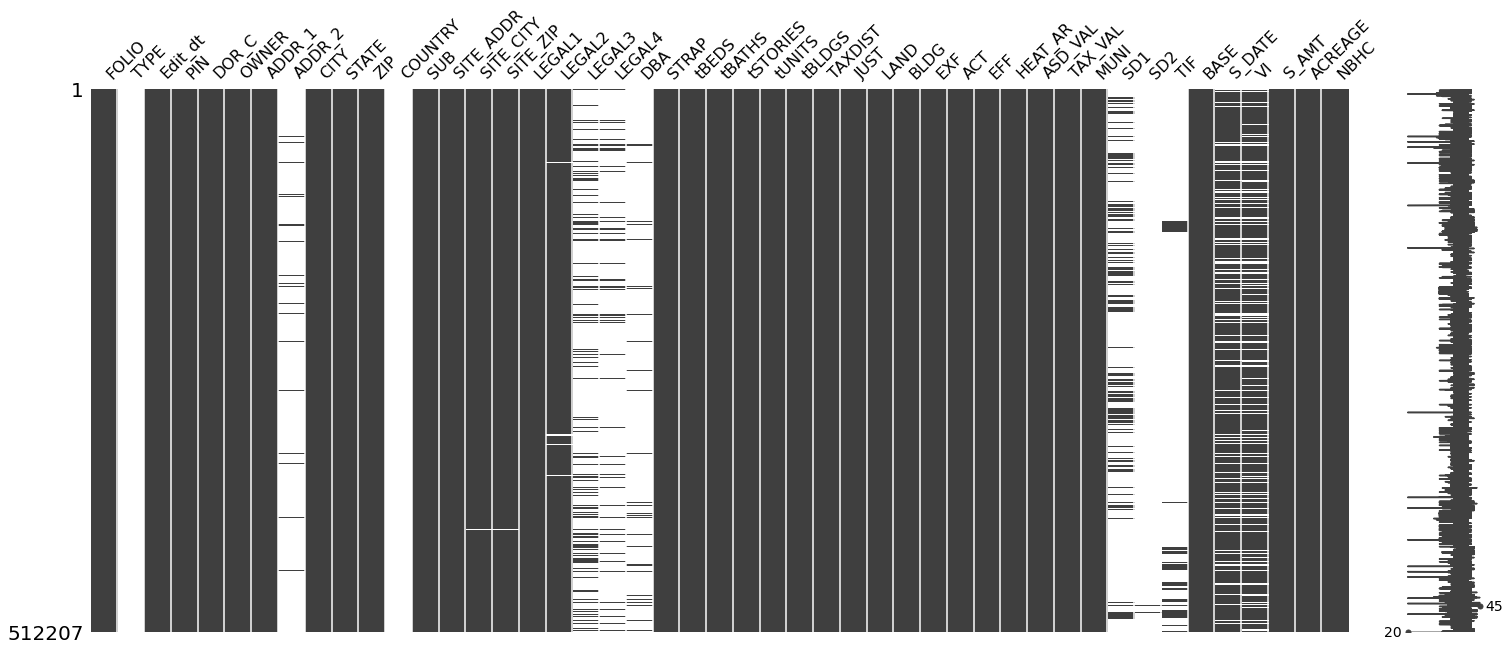

In [8]:
# Visualize missingness matrix
msno.matrix(parcel_df)
plt.show()

### Drop columns where data is missing or not valuable
- TYPE: empty
- Edit_dt: date mapping polygon was last updated
- COUNTRY: empty
- LEGAL1: legal description line 1 (text description; legal codes found in other columns)
- LEGAL2: legal description line 2 (text description; legal codes found in other columns)
- LEGAL3: legal description line 3 (text description; legal codes found in other columns)
- LEGAL4: legal description line 4 (text description; legal codes found in other columns)
- DBA: Doing Business As; business name
- STRAP: unformatted PIN number (duplicate data)
- S_DATE: last sale date of qualified [free market] sales only since 1906 (sale dates will be obtained from sales data)
- S_AMT: last sale amount of qualified sales only (sale amounts will be obtained from sales data)

In [9]:
# Drop columns where data is missing or not valueable
pd_cols = ['TYPE', 'Edit_dt', 'COUNTRY', 'LEGAL1', 'LEGAL2', 'LEGAL3', 'LEGAL4', 'DBA', 'STRAP', 'S_DATE', 'S_AMT']
parcel_df.drop(pd_cols, axis=1, inplace=True)

# 3 Property Site Address<a id='3'></a>
- Validate data
- Impute missing data

In [10]:
# Validate Site Street Address exists for all parcel records that have a Property Identification Number (PIN)
assert parcel_df[(parcel_df['SITE_ADDR'].isna()) & (parcel_df['PIN'].notnull())].shape[0] == 0

In [11]:
# Replace any invalid zip formats with '99999'
invalid_zip_format = (parcel_df['SITE_ZIP'].isna()) | (parcel_df['SITE_ZIP'].str.len() < 5)
parcel_df.loc[invalid_zip_format, 'SITE_ZIP'] = '99999'

# If Site Street Address fuzzy matches to Owner Street Address replace Site Zip of '99999' with Owner Zip
invalid_zip_value = (parcel_df['SITE_ZIP'] == '99999') & (fuzz.WRatio(parcel_df['SITE_ADDR'], parcel_df['ADDR_1']) >= 80)
parcel_df.loc[invalid_zip_value, 'SITE_ZIP'] = parcel_df['ZIP']

In [12]:
# Fill missing Site City with Owner City if Zip Codes match
missing_city = ((parcel_df['SITE_CITY'].isna()) | (parcel_df['SITE_CITY'].str.len() < 4)) & (parcel_df['SITE_ZIP'].str[:5] == parcel_df['ZIP'].str[:5])
parcel_df.loc[missing_city, 'SITE_CITY'] = parcel_df['CITY']

In [13]:
# Fill missing Site Street Address if Zip Codes match
missing_addr = (parcel_df['SITE_ADDR'].str.len() < 4) & (parcel_df['SITE_ZIP'].str[:5] == parcel_df['ZIP'].str[:5])
parcel_df.loc[missing_addr, 'SITE_ADDR'] = (parcel_df['ADDR_1'] + ' ' + parcel_df['ADDR_2']).str.strip()

In [14]:
# Missing Data
p_missing = pd.concat([parcel_df.isnull().sum(), 100 * parcel_df.isnull().mean()], axis=1)
p_missing.columns=['count', '%']
p_missing.sort_values(by=['count', '%'], ascending=[False, False])

,count,%
SD2,509168,99.406685
ADDR_2,492466,96.145894
TIF,466465,91.069626
SD1,391945,76.520821
VI,102700,20.050487
SITE_ADDR,4161,0.812367
STATE,3104,0.606005
ZIP,3087,0.602686
CITY,1121,0.218857
ADDR_1,815,0.159115


### Drop Owner Name and Address Data

In [15]:
pd_cols = ['OWNER', 'ADDR_1', 'ADDR_2', 'CITY', 'STATE', 'ZIP']
parcel_df.drop(pd_cols, axis=1, inplace=True)
print(parcel_df.shape)

(512207, 30)


# 4 Read Sales file into dataframe<a id='4'></a>

In [16]:
sales_df = pd.read_csv(raw_data + 'sales_df.csv', dtype={'FOLIO': object, 'DOR_CODE': str, 'NBHC': object, 'STR': object, 'OR_BK': object, 'OR_PG': object, 'DOC_NUM': object})

In [17]:
print(sales_df.shape)
print(sales_df.info())

(2166282, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2166282 entries, 0 to 2166281
Data columns (total 17 columns):
 #   Column    Dtype  
---  ------    -----  
 0   PIN       object 
 1   FOLIO     object 
 2   DOR_CODE  object 
 3   NBHC      object 
 4   S_DATE    object 
 5   VI        object 
 6   QU        object 
 7   REA_CD    object 
 8   S_AMT     float64
 9   SUB       object 
 10  STR       object 
 11  S_TYPE    object 
 12  OR_BK     object 
 13  OR_PG     object 
 14  GRANTOR   object 
 15  GRANTEE   object 
 16  DOC_NUM   object 
dtypes: float64(1), object(16)
memory usage: 281.0+ MB
None


In [18]:
sales_df.head().T

,0,1,2,3,4
PIN,A-23-33-15-ZZZ-000000-00040.0,U-01-27-17-001-000000-00001.0,U-01-27-17-001-000000-00001.0,U-01-27-17-001-000000-00001.0,U-01-27-17-001-000000-00001.0
FOLIO,0000050000,0000080000,0000080000,0000080000,0000080000
DOR_CODE,8600,0000,0000,0000,0000
NBHC,227002.0,211007.0,211007.0,211007.0,211007.0
S_DATE,1928-03-01,2019-09-16,2014-04-01,2006-12-05,1988-10-01
VI,V,V,V,V,V
QU,U,U,U,U,U
REA_CD,38,11,11,11,38
S_AMT,100.0,100.0,100.0,100.0,28000.0
SUB,ZZZ,001,001,001,001


In [19]:
# Replace blank strings with NaN
sales_df = sales_df.replace(r'^\s*$', np.NaN, regex=True)

In [20]:
# Missing Data
s_missing = pd.concat([sales_df.isnull().sum(), 100 * parcel_df.isnull().mean()], axis=1)
s_missing.columns=['count', '%']
s_missing.sort_values(by=['count', '%'], ascending=[False, False])

,count,%
GRANTOR,729426.0,NaN
GRANTEE,620707.0,NaN
DOC_NUM,265596.0,NaN
S_TYPE,79678.0,NaN
VI,67887.0,20.050487
REA_CD,15833.0,NaN
OR_BK,14190.0,NaN
OR_PG,14190.0,NaN
DOR_CODE,18.0,NaN
PIN,0.0,0.005467


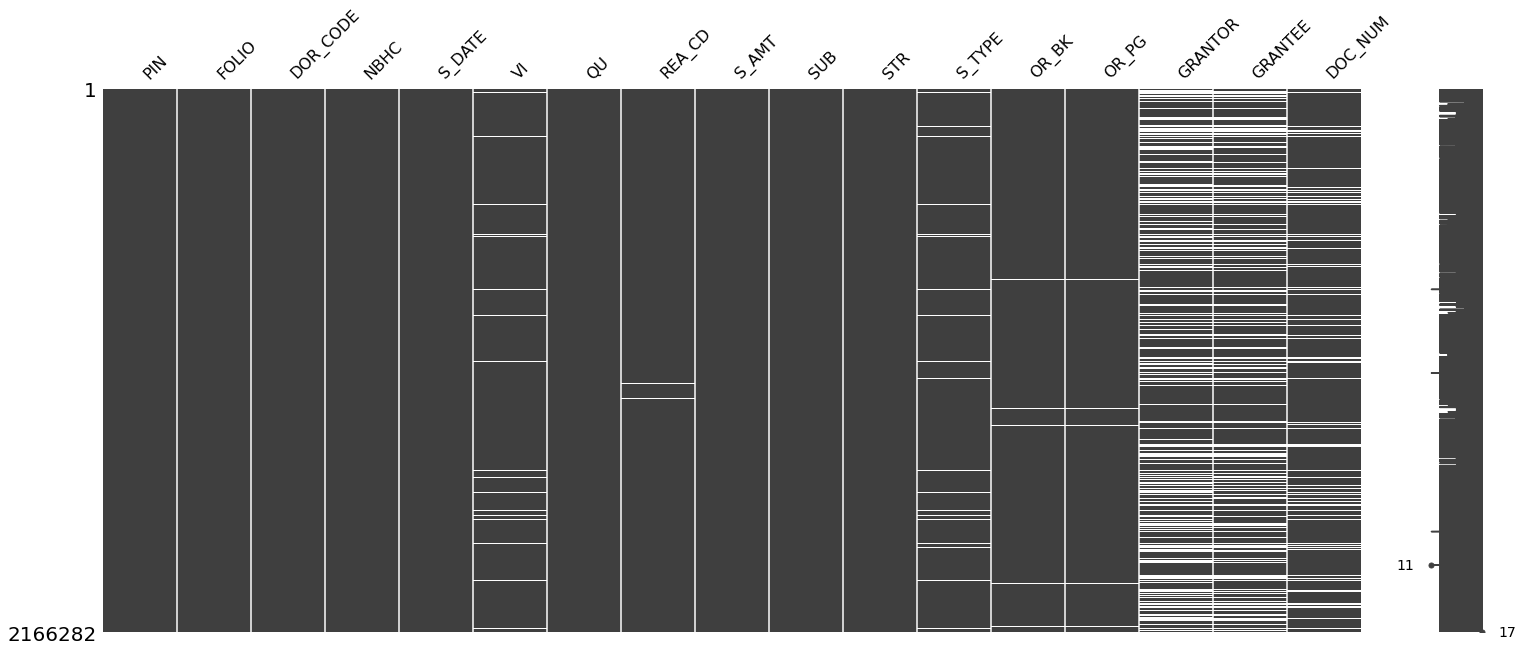

In [21]:
# Visualize missingness matrix
msno.matrix(sales_df)
plt.show()

### Drop columns where data is missing or not valuable
- OR_BK: book number where the deed is recorded
- OR_PG: page number where the deed is recorded
- GRANTOR: seller name
- GRANTEE: buyer name
- DOC_NUM: instrument number from Clerk’s Office

In [22]:
# Drop columns where data is missing or not valuable
sd_cols = ['OR_BK', 'OR_PG', 'GRANTOR', 'GRANTEE', 'DOC_NUM']
sales_df.drop(sd_cols, axis=1, inplace=True)
print(sales_df.shape)

(2166282, 12)


# 5 Sales Date<a id='5'></a>
- Validate no missing values
- Convert to datetime data type
- Evaluate totals
- Drop outlier data

In [23]:
sales_df['S_DATE'].describe()

count        2166282
unique         11447
top       1976-01-01
freq           10239
Name: S_DATE, dtype: object

In [24]:
assert sales_df[sales_df['S_DATE'].isna()].shape[0] == 0

In [25]:
sales_df['S_DATE'] = pd.to_datetime(sales_df['S_DATE'])

In [26]:
# Add original sale date to obtain age of property
sales_df['ORIG_SALES_DATE'] = sales_df.groupby('FOLIO')['S_DATE'].transform(np.min)

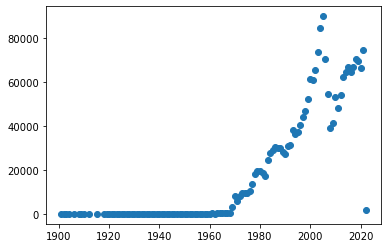

In [27]:
year_totals = pd.DataFrame(sales_df.groupby(sales_df['S_DATE'].dt.year).size())
plt.scatter(year_totals.index, year_totals[0])
plt.show()

In [28]:
# The top date was 1976-01-01 with 10239 sales.
# This appears that some properties may have been initialized with that date.
# Drop data for years prior to 1980
sales_df = sales_df[sales_df['S_DATE'] >= '1980-01-01']
sales_df.shape

(2047229, 13)

# 6 Merge Sales and Parcel Data<a id='6'></a>
- Left Merge based on Folio number
- Analyze missing parcel data

In [29]:
sales_df = sales_df.merge(parcel_df, on='FOLIO', how='left', indicator=True, suffixes=('', '_p'))

In [30]:
sales_df.head().T

,0,1,2,3,4
PIN,U-01-27-17-001-000000-00001.0,U-01-27-17-001-000000-00001.0,U-01-27-17-001-000000-00001.0,U-01-27-17-001-000000-00001.0,U-01-27-17-001-000000-00001.0
FOLIO,0000080000,0000080000,0000080000,0000080000,0000080000
DOR_CODE,0000,0000,0000,0000,0000
NBHC,211007.0,211007.0,211007.0,211007.0,211007.0
S_DATE,2019-09-16 00:00:00,2014-04-01 00:00:00,2006-12-05 00:00:00,1988-10-01 00:00:00,1980-05-01 00:00:00
VI,V,V,V,V,V
QU,U,U,U,U,U
REA_CD,11,11,11,38,38
S_AMT,100.0,100.0,100.0,28000.0,100.0
SUB,001,001,001,001,001


In [31]:
parcel_missing = sales_df[sales_df['_merge'] == 'left_only']
parcel_missing.shape

(1350, 43)

In [32]:
# Save sales with missing parcel data to csv
parcel_missing.to_csv(interim_data + 'parcel_missing.csv')

In [33]:
percent_missing = (parcel_missing.shape[0] / sales_df.shape[0]) * 100
print('Percent of sales with missing parcel data: ' + str(round(percent_missing, 3)) + '%')

Percent of sales with missing parcel data: 0.066%


### Drop sales with missing parcel data
- It is unclear as to why 0.066% of the sales data does not have a matching record in the parcel data.
- Further analysis of the missing data would require an investigation into the source systems.
- Decision is to exclude these sales from the analysis.

In [34]:
sales_df = sales_df[sales_df['_merge'] == 'both']
sales_df.drop('_merge', axis=1, inplace=True)
sales_df.shape

(2045879, 42)

# 7 PIN - Property Identification Number<a id='7'></a>
- Validate format
- Unpack data elements into new columns
- Drop original column

The PIN number is the parcel identifier and is formatted as follows.

Example PIN: A-16-28-19-3A3-000034-00004.0

A 16 28 19 3A3 000034 00004.0 (Municipality) (Section) (Township) (Range) (Land Type-ID) (Block# ) (Lot#)

The MUNICIPALITY CODE indicates whether the property is located in a city or unincorporated county. The code for the City of Tampa is "A", for the City of Temple Terrace "T" and for the City of Plant City "P". All unincorporated county is coded with "U".

The SECTION-TOWNSHIP-RANGE

The Land Type-ID is to further identify the type of land. All platted Subdivisions and Condominiums have been assigned an ID number. This number may be a combination of numbers and letters, such as "3A3". Not all property in the county is platted. For all unplatted, metes and bounds described lands a Land Type-ID of "ZZZ" has been assigned. This way, one look at the PIN number can tell you whether it is platted or unplatted land.

The BLOCK# is 6 digits and will hold the Block Number in platted Subdivisions or Building Number in a Condominium. For unplatted land having a Land Type-ID of "ZZZ" the BLOCK# will carry a uniquely assigned number.

The LOT# is 6 digits and will hold the Lot Numbers in Platted Subdivisions or Unit Numbers in a Condominium. For all unplatted land having a Land Type-ID of "ZZZ" the LOT# will carry a uniquely assigned number.

In [35]:
print(sales_df['PIN'].describe())

count                           2045879
unique                           495133
top       U-36-27-18-ZZZ-000000-75670.1
freq                                 83
Name: PIN, dtype: object


In [36]:
# Validate all PIN's match format (i.e. 'A-16-28-19-3A3-000034-00004.0')
pin = sales_df['PIN'].str.match("^[A-Z]-\d{2}-\d{2}-\d{2}-[A-Z0-9]{3}-[A-Z0-9]{6}-[A-Z0-9]{5}\.[A-Z0-9]$")
assert sales_df[~pin].shape[0] == 0

In [37]:
# Split PIN into the seven data elements that are used to create the PIN
pin_fields = ['MUNICIPALITY_CD', 'SECTION_CD', 'TOWNSHIP_CD', 'RANGE_CD', 'LAND_TYPE_ID', 'BLOCK_NUM', 'LOT_NUM']
sales_df[pin_fields] = sales_df['PIN'].str.split('-', expand=True).astype('category')

In [38]:
# FOLIO and PIN (Property Identification Number) are both unique values that describe the properties
# Drop PIN as the values have already been segregated into the 7 data elements that make up the PIN
sales_df.drop(['PIN', 'PIN_p'], axis=1, inplace=True)

# 8 DOR Code - Department of Revenue Code<a id='8'></a>
There are almost 300 Department of Revenue (DOR) codes which represent the type of property.  The types of properties include single family homes, condos, malls, night clubs, churches, vacant land, etc. 

In [39]:
# read external list of DOR codes
dor_code_df = pd.read_excel(open(ext_data + '_DOR_CODE_LIST.xlsx','rb'), sheet_name='parcel_dor_names')
dor_code_df.head()

,DORCODE,DORDESCR
0,0000,VACANT RESIDENTIAL
1,0006,VACANT TOWNHOME
2,0008,VACANT MH/CONDO COOP
3,0029,PUBLIC LANDS
4,0040,VACANT CONDO


In [40]:
dor_code_df.describe()

,DORCODE,DORDESCR
count,288,288
unique,288,288
top,0000,VACANT RESIDENTIAL
freq,1,1


In [41]:
print(sales_df['DOR_CODE'].describe())
print('# of missing DOR codes: ' + str(sales_df[sales_df['DOR_CODE'].isna()].shape[0]))

count     2045861
unique        269
top          0100
freq      1411648
Name: DOR_CODE, dtype: object
# of missing DOR codes: 18


In [42]:
# fill missing values of sales DOR_CODE with parcel DOR_C
sales_df['DOR_CODE'].fillna(sales_df['DOR_C'], inplace=True)
assert sales_df[sales_df['DOR_CODE'].isna()].shape[0] == 0

Text(0.5, 0, 'Count')

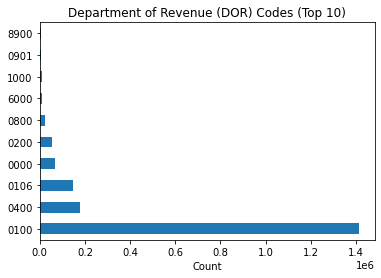

In [43]:
ax = sales_df.DOR_CODE.value_counts(dropna=False).head(10).plot(kind='barh', title='Department of Revenue (DOR) Codes (Top 10)')
ax.set_xlabel('Count')

In [44]:
# Query any DOR codes in sales data that do not exist in the DOR code list
sales_dor = sales_df.merge(dor_code_df, left_on='DOR_CODE', right_on='DORCODE', how='left', indicator=True)
dor_list = sales_dor.loc[sales_dor['_merge'] == 'left_only', 'DOR_CODE']
invalid_dor_codes = sales_df[sales_df['DOR_CODE'].isin(dor_list)]

In [45]:
print(invalid_dor_codes.shape)
print(invalid_dor_codes.groupby('DOR_CODE', dropna=False).size())

(4521, 47)
DOR_CODE
1050     199
1421     593
1422     683
1423     232
1750    1420
1751      24
1851      22
1950     666
1951      51
4801      24
4802      50
4803      44
4804      14
7150       4
7301      33
7501     447
7550      11
9929       4
dtype: int64


The other DOR codes that are not in the validation list appear to fall into the following categories:
- 1000 level: Vacant Commercial
- 1400 level: Supermarkets/Convenience Stores
- 1700 level: Office, One-Story
- 1800 level: Office, Multi-Story
- 1900 level: Medical Office
- 4800 level: Warehouse/Distribution Terminals
- 7100 level: Churches
- 7300 level: Hospitals
- 7500 level: Non-Profit Services
- 9900 level: Vacant Acreage

For this analysis, the following residential property types will be used:
- 0100: Single Family Residential
- 0102: Single family home built around a mobile home
- 0106: Townhouse/Villa
- 0200: Mobile Home
- 0400: Condominium
- 0408: Mobile Home Condominium
- 0800: Multi-Family Residential (Duplex, Triplex, Quadplex, etc.) < 10 units
- 0801: Multi-Family Residential (units individually owned)
- 0802: Multi-Family Residential (units rentals)

In [46]:
dor_residential = ['0100', '0102', '0106', '0200', '0400', '0408', '0800', '0801', '0802']
sales_df = sales_df[sales_df['DOR_CODE'].isin(dor_residential)]
sales_df.drop('DOR_C', axis=1, inplace=True)
sales_df.shape

(1817623, 46)

# 9 NBHC - Neighborhood Code<a id='9'></a>
- Validate current values of NBHC_p from Parcel data (Parcel data is current where Sales data could have changed over time)
- Drop NBHC from Sales data
- Rename NBHC_p to NBHC

count      1817623
unique         313
top       228003.0
freq         33286
Name: NBHC_p, dtype: object


Text(0.5, 0, 'Count')

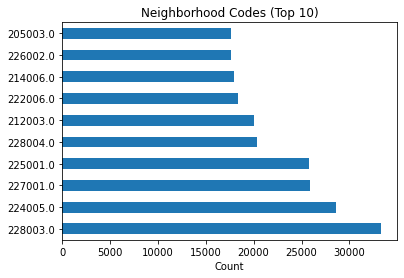

In [47]:
print(sales_df['NBHC_p'].describe())
ax = sales_df.NBHC_p.value_counts(dropna=False).head(10).plot(kind='barh', title='Neighborhood Codes (Top 10)')
ax.set_xlabel('Count')

In [48]:
assert sales_df[sales_df['NBHC_p'].isna()].shape[0] == 0

In [49]:
sales_df.drop('NBHC', axis=1, inplace=True)
sales_df.rename(columns = {'NBHC_p': 'NBHC'}, inplace=True)

# 10 VI - Vacant or Improved at time of sale<a id='10'></a>
- Validate current values of 'V', 'I', NaN
- Impute missing values
- Drop VI_p parcel column

In [50]:
print(sales_df['VI'].describe())
print(sales_df.groupby('VI', dropna=False).size())

count     1816646
unique          2
top             I
freq      1482652
Name: VI, dtype: object
VI
I      1482652
V       333994
NaN        977
dtype: int64


In [51]:
# fill missing values of sales VI with parcel VI_p
sales_df['VI'].fillna(sales_df['VI_p'], inplace=True)
print(sales_df.groupby('VI', dropna=False).size())

VI
I      1483289
V       334037
NaN        297
dtype: int64


<AxesSubplot:title={'center':'Missing VI Codes'}, ylabel='Count'>

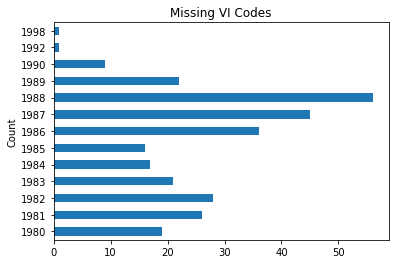

In [52]:
# Analyze missing VI codes
missing_vi = sales_df[sales_df['VI'].isna()]
missing_vi.groupby(missing_vi['S_DATE'].dt.year).size().plot(kind='barh', title='Missing VI Codes', ylabel='Year', xlabel='Count')

In [53]:
# remaining missing values of sales VI appear to be older sales records...assume Improved
sales_df['VI'].fillna('I', inplace=True)
assert sales_df[sales_df['VI'].isna()].shape[0] == 0

In [54]:
sales_df.drop('VI_p', axis=1, inplace=True)

# 11 QU - Qualified or Unqualified<a id='11'></a>
Qualified sales are free market sales and are used by the Property Appraiser to determine property values.
Unqualified sales are multi-parcel sales, deed transfers, or sales with other considerations than money.
For this analysis, Unqualified sales should be excluded.
- Validate only Q and U exist
- Remove Unqualified sales

In [55]:
print(sales_df['QU'].describe())
print(sales_df.groupby('QU', dropna=False).size())

count     1817623
unique          2
top             U
freq       970430
Name: QU, dtype: object
QU
Q    847193
U    970430
dtype: int64


In [56]:
sales_df = sales_df[sales_df['QU'] == 'Q']
sales_df.shape

(847193, 44)

# 12 REA Code - Reason Code for Qualified or Unqualified<a id='12'></a>
- Validate current values 
- Impute missing values

count     832669
unique        25
top           01
freq      543708
Name: REA_CD, dtype: object


Text(0.5, 0, 'Count')

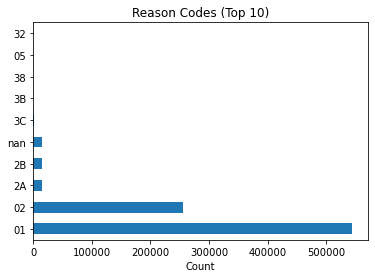

In [57]:
print(sales_df['REA_CD'].describe())
ax = sales_df.REA_CD.value_counts(dropna=False).head(10).plot(kind='barh', title='Reason Codes (Top 10)')
ax.set_xlabel('Count')

In [58]:
# set missing reason codes to '00' since there is no way to determine the correct reason code without in depth research into source systems
sales_df['REA_CD'].fillna('00', inplace=True)
assert sales_df[sales_df['REA_CD'].isna()].shape[0] == 0

# 13 Sale Amount<a id='13'></a>
- Validate current values

In [59]:
print(sales_df['S_AMT'].describe().apply(lambda x: format(x, 'f')))

count      847193.000000
mean       199161.203110
std        422183.918268
min            47.000000
25%         76600.000000
50%        142000.000000
75%        235000.000000
max      41200000.000000
Name: S_AMT, dtype: object


The Sales Amounts are skewed by low values that appear to be invalid.
- The minimum amount is \$47
- Create bins to identify and research outliers
- Drop outliers

In [60]:
amt_bins = [0, 1000, 10000, 50000, 100000, 500000, 1000000, 10000000, 30000000, 50000000]
amt_bins.append(float('inf'))
sales_df['S_AMT_BIN'] = pd.cut(sales_df['S_AMT'], bins=amt_bins)

In [61]:
sales_df.groupby('S_AMT_BIN').size()

S_AMT_BIN
(0.0, 1000.0]                   72
(1000.0, 10000.0]             4326
(10000.0, 50000.0]          101369
(50000.0, 100000.0]         194039
(100000.0, 500000.0]        512358
(500000.0, 1000000.0]        27375
(1000000.0, 10000000.0]       7185
(10000000.0, 30000000.0]       450
(30000000.0, 50000000.0]        19
(50000000.0, inf]                0
dtype: int64

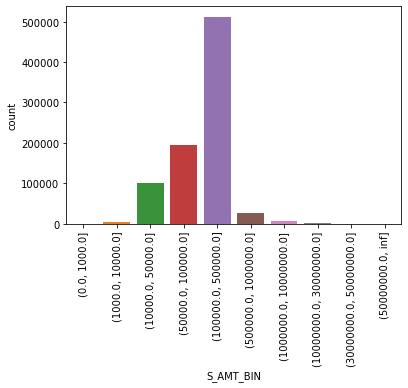

In [62]:
ax = sns.countplot(data=sales_df, x='S_AMT_BIN')
ax.tick_params(axis='x', labelrotation=90)

In [63]:
sales_df.loc[sales_df['S_AMT'] >= 30000000, ['S_AMT', 'S_DATE', 'SITE_ADDR', 'SITE_CITY']]

,S_AMT,S_DATE,SITE_ADDR,SITE_CITY
1078209,39170000.0,1982-03-01,608 CEDAR GROVE DR,BRANDON
1955260,41200000.0,2001-04-12,345 BAYSHORE BLVD 809,TAMPA
1973136,31495000.0,1983-08-01,916 ANCHORAGE RD,TAMPA
1973157,31495000.0,1983-08-01,922 ANCHORAGE RD,TAMPA
1973194,31495000.0,1983-08-01,911 MOORING CIR,TAMPA
1973200,31495000.0,1983-08-01,915 MOORING CIR,TAMPA
1973206,31495000.0,1983-08-01,917 MOORING CIR,TAMPA
1973210,31495000.0,1983-08-01,919 MOORING CIR,TAMPA
1973229,31495000.0,1983-08-01,919 ANCHORAGE RD,TAMPA
1973244,31495000.0,1983-08-01,923 ANCHORAGE RD,TAMPA


In [64]:
sales_df.loc[sales_df['S_AMT'] <= 1000, ['S_AMT', 'S_DATE', 'SITE_ADDR', 'SITE_CITY']]

,S_AMT,S_DATE,SITE_ADDR,SITE_CITY
130866,1000.0,1984-05-01,8801 BRIAR HOLLOW CT,TAMPA
165582,1000.0,1987-01-01,6308 NEWTOWN CIR 08A1,TAMPA
242391,1000.0,1982-04-01,3628 BERGER RD,LUTZ
254568,700.0,2006-04-11,16018 WOODPINE DR,TAMPA
254791,1000.0,1985-05-01,16137 RAVENDALE DR,TAMPA
...,...,...,...,...
1899894,101.0,2018-10-15,1108 W CORAL ST,TAMPA
1933984,900.0,1982-02-01,2305 E 23RD AVE,TAMPA
1934484,1000.0,1982-08-01,2417 E 20TH AVE,TAMPA
1935012,1000.0,1984-01-01,NaN,TAMPA


In [65]:
# Researched outliers and determined that they appear to be invalid amounts
#   Drop outliers of properties sold for $1000 or less
#   Drop outliers of properties sold for $30,000,000 or more
sales_df = sales_df[(sales_df['S_AMT'] > 1000) & (sales_df['S_AMT'] < 30000000)]
sales_df.drop('S_AMT_BIN', axis=1, inplace=True)
sales_df.shape

(847102, 44)

# 14 Subdivision Code / Land Type ID<a id='14'></a>
- Validate current values
- Validate the Land Type ID that was unpacked from the PIN is the same as the Subdivision Code
- Drop duplicate columns

count     847102
unique      8814
top          ZZZ
freq       34656
Name: SUB, dtype: object


Text(0.5, 0, 'Count')

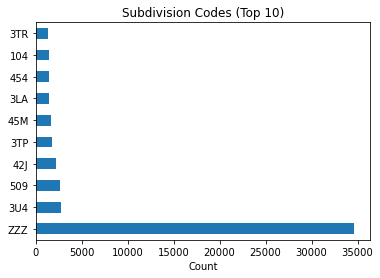

In [66]:
print(sales_df['SUB'].describe())
ax = sales_df.SUB.value_counts(dropna=False).head(10).plot(kind='barh', title='Subdivision Codes (Top 10)')
ax.set_xlabel('Count')

In [67]:
assert sales_df[sales_df['SUB'].isna()].shape[0] == 0
assert sales_df[sales_df['SUB'] != sales_df['SUB_p']].shape[0] == 0
assert sales_df[sales_df['SUB'] != sales_df['LAND_TYPE_ID']].shape[0] == 0

In [68]:
sales_df.drop(['SUB', 'SUB_p'], axis=1, inplace=True)

# 15 STR - Section Township Range<a id='15'></a>
- Validate current values
- Validate STR is the same value as the Section, Township, and Range unpacked from the PIN
- Drop duplicate columns

count     847102
unique       812
top       332920
freq        6221
Name: STR, dtype: object


Text(0.5, 0, 'Count')

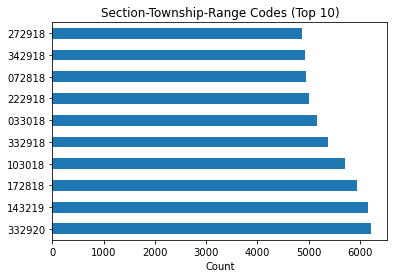

In [69]:
print(sales_df['STR'].describe())
ax = sales_df.STR.value_counts(dropna=False).head(10).plot(kind='barh', title='Section-Township-Range Codes (Top 10)')
ax.set_xlabel('Count')

In [70]:
assert sales_df[sales_df['STR'].str[:2] != sales_df['SECTION_CD']].shape[0] == 0
assert sales_df[sales_df['STR'].str[2:4] != sales_df['TOWNSHIP_CD']].shape[0] == 0
assert sales_df[sales_df['STR'].str[4:] != sales_df['RANGE_CD']].shape[0] == 0

In [71]:
sales_df.drop('STR', axis=1, inplace=True)

# 16 S_TYPE - legal instrument recorded at County Clerk's office<a id='16'></a>
- Validate current values
- Imput missing values

count     846877
unique        18
top           WD
freq      834201
Name: S_TYPE, dtype: object


Text(0.5, 0, 'Count')

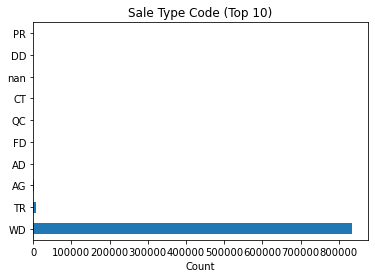

In [72]:
print(sales_df['S_TYPE'].describe())
ax = sales_df.S_TYPE.value_counts(dropna=False).head(10).plot(kind='barh', title='Sale Type Code (Top 10)')
ax.set_xlabel('Count')

In [73]:
# set missing reason codes to '00' since there is no way to determine the correct code without in depth research into source systems
sales_df['S_TYPE'].fillna('00', inplace=True)
assert sales_df[sales_df['S_TYPE'].isna()].shape[0] == 0

# 17 Municipality Code <a id='17'></a>
- A=Tampa, U=Unincorporated, T=Temple Terrace, P=Plant City
- Validate current values
- Impute missing values
- Drop duplicate columns

count     847102
unique         4
top            U
freq      589960
Name: MUNICIPALITY_CD, dtype: object


Text(0.5, 0, 'Count')

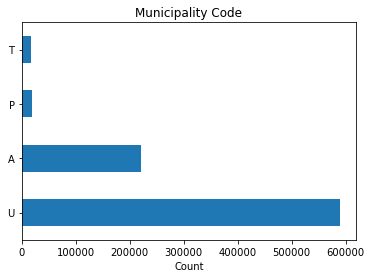

In [74]:
print(sales_df['MUNICIPALITY_CD'].describe())
ax = sales_df.MUNICIPALITY_CD.value_counts(dropna=False).plot(kind='barh', title='Municipality Code')
ax.set_xlabel('Count')

In [75]:
assert sales_df[sales_df['MUNICIPALITY_CD'] != sales_df['MUNI']].shape[0] == 0

In [76]:
sales_df['TAXDIST'] = sales_df['TAXDIST'].map({'PC': 'P', 'TA': 'A', 'TT': 'T', 'U': 'U'})
assert sales_df[sales_df['MUNICIPALITY_CD'] != sales_df['TAXDIST']].shape[0] == 0

In [77]:
sales_df.drop(['MUNI', 'TAXDIST'], axis=1, inplace=True)

# 18 SD1 & SD2 - Special Tax District<a id='18'></a>
- Validate current values
- Impute missing values

count     211140
unique       168
top          702
freq       16449
Name: SD1, dtype: object


Text(0.5, 0, 'Count')

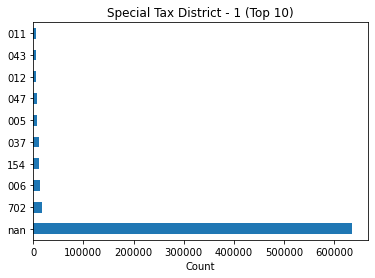

In [78]:
print(sales_df['SD1'].describe())
ax = sales_df.SD1.value_counts(dropna=False).head(10).plot(kind='barh', title='Special Tax District - 1 (Top 10)')
ax.set_xlabel('Count')

count     4770
unique       7
top        201
freq      3578
Name: SD2, dtype: object


Text(0.5, 0, 'Count')

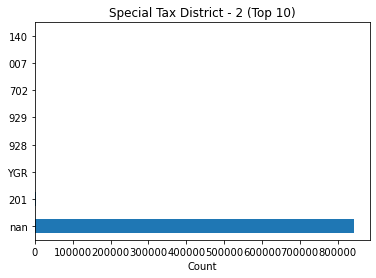

In [79]:
print(sales_df['SD2'].describe())
ax = sales_df.SD2.value_counts(dropna=False).head(10).plot(kind='barh', title='Special Tax District - 2 (Top 10)')
ax.set_xlabel('Count')

In [80]:
# set missing codes to '000' since there is no way to determine the correct code without in depth research into source systems
sales_df['SD1'].fillna('000', inplace=True)
sales_df['SD2'].fillna('000', inplace=True)
assert sales_df[sales_df['SD1'].isna()].shape[0] == 0
assert sales_df[sales_df['SD2'].isna()].shape[0] == 0

# 19 TIF - Tax increment fund<a id='19'></a>
- Validate current values
- Impute missing values

count     61384
unique       15
top           E
freq      30826
Name: TIF, dtype: object


Text(0.5, 0, 'Count')

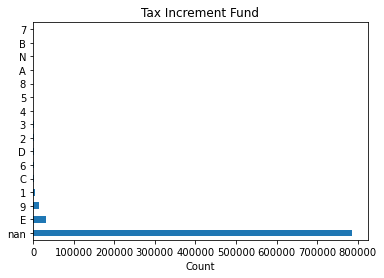

In [81]:
print(sales_df['TIF'].describe())
ax = sales_df.TIF.value_counts(dropna=False).plot(kind='barh', title='Tax Increment Fund')
ax.set_xlabel('Count')

In [82]:
# set missing codes to '0' since there is no way to determine the correct code without in depth research into source systems
sales_df['TIF'].fillna('0', inplace=True)
assert sales_df[sales_df['TIF'].isna()].shape[0] == 0

# 20 Property Attributes<a id='20'></a>
- tBEDS: total bedrooms for all buildings on parcel
- tBATHS: total bathrooms for all buildings on parcel
- tUNITS: total living units for all buildings on parcel
- tSTORIES: total number of floors for all buildings
- tBLDGS: total number of buildings on parcel
- HEAT_AR: heated sq feet (living area) of all buildings on a parcel
- ACREAGE: area (calculated from the polygon, not based on the deed)
- Validate current values

In [83]:
sales_df[['tBEDS', 'tBATHS', 'tUNITS', 'tSTORIES', 'tBLDGS', 'HEAT_AR', 'ACREAGE']].describe().apply(lambda s: s.apply('{0:.2f}'.format))

,tBEDS,tBATHS,tUNITS,tSTORIES,tBLDGS,HEAT_AR,ACREAGE
count,847102.00,847102.00,847102.00,847102.00,847102.00,847102.00,847102.00
mean,3.12,2.22,1.02,1.29,0.81,1860.36,0.28
std,0.97,0.78,0.25,0.50,0.42,853.53,0.70
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,3.00,2.00,1.00,1.00,1.00,1283.00,0.11
50%,3.00,2.00,1.00,1.00,1.00,1674.00,0.17
75%,4.00,2.50,1.00,2.00,1.00,2237.00,0.25
max,24.00,17.00,9.00,11.00,9.00,28893.00,102.65


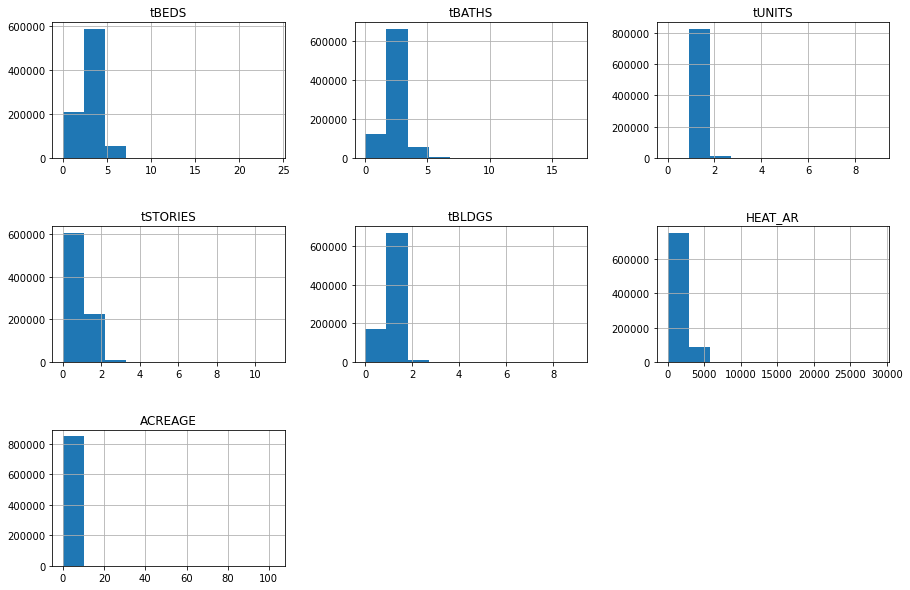

In [84]:
sales_df[['tBEDS', 'tBATHS', 'tUNITS', 'tSTORIES', 'tBLDGS', 'HEAT_AR', 'ACREAGE']].hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);
# terminating ';' "swallows" some messy output and leads to a tidier notebook

# 21 Current Values of Property<a id='21'></a>
- JUST: market/just value 
- LAND: value of land
- BLDG: value of all buildings on parcel
- EXF: value of all extra features on parcel (fences, dock, utility shed, pool)
- ASD_VAL: assessed value (value of land & improvements)
- TAX_VAL: taxable value (asd_val less any exemptions)
- Validate current values

In [85]:
sales_df[['JUST', 'LAND', 'BLDG', 'EXF', 'ASD_VAL', 'TAX_VAL']].describe().apply(lambda s: s.apply('{0:.2f}'.format))

,JUST,LAND,BLDG,EXF,ASD_VAL,TAX_VAL
count,847102.00,847102.00,847102.00,847102.00,847102.00,847102.00
mean,294145.41,78944.40,206857.75,8274.24,211092.17,175994.74
std,240877.79,99046.78,158483.00,13634.72,193869.45,194630.69
min,3650.00,75.00,0.00,0.00,2725.00,0.00
25%,179629.00,40859.00,130541.00,0.00,112457.00,74042.25
50%,246876.50,64260.00,175362.00,1361.00,172631.00,137519.00
75%,340266.75,91072.00,238370.25,12173.00,251333.00,219865.00
max,16539559.00,8673113.00,9840672.00,409781.00,16539559.00,16539559.00


In [86]:
# Fill TAX_VAL with ASD_VAL
sales_df.loc[sales_df['TAX_VAL'] == 0, 'TAX_VAL'] = sales_df['ASD_VAL']

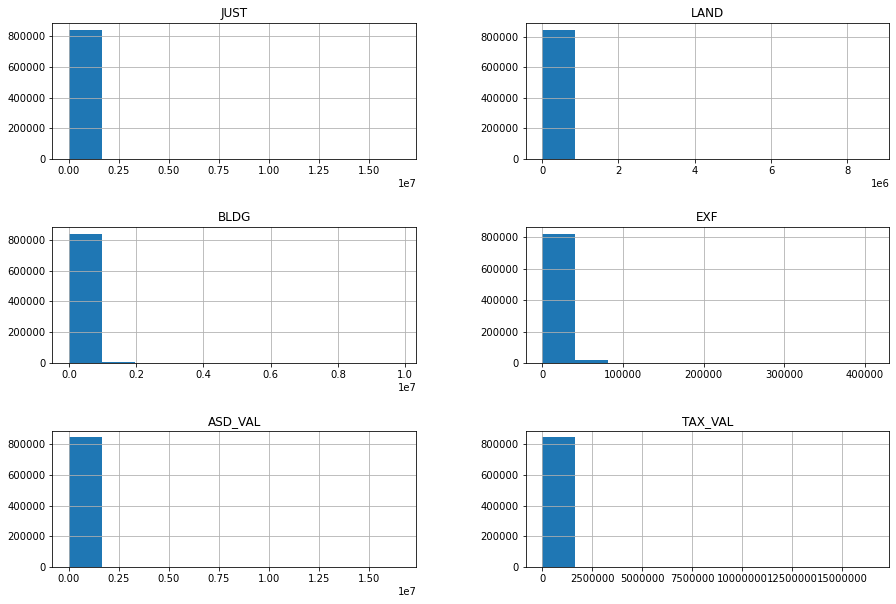

In [87]:
sales_df[['JUST', 'LAND', 'BLDG', 'EXF', 'ASD_VAL', 'TAX_VAL']].hist(figsize=(15,10))
plt.ticklabel_format(useOffset=False, style='plain', axis='both')
plt.subplots_adjust(hspace=0.5);
# terminating ';' "swallows" some messy output and leads to a tidier notebook

# 22 Year Data<a id='22'></a>
- ACT: actual year built 
- EFF: effective year to calculate depreciation
- BASE: year homestead approved 
<br><br>
- Validate current values
- Impute missing values with original sales date

In [88]:
sales_df[['ACT', 'EFF', 'BASE']].describe()

,ACT,EFF,BASE
count,847102,847102,847102
unique,134,105,30
top,2001,2013,0
freq,26090,69961,292645


In [89]:
sales_df.loc[sales_df['ACT'] == '0', 'ACT'] = sales_df['ORIG_SALES_DATE'].dt.year
sales_df.loc[sales_df['EFF'] == '0', 'EFF'] = sales_df['ORIG_SALES_DATE'].dt.year
sales_df.loc[sales_df['BASE'] == '0', 'BASE'] = sales_df['ORIG_SALES_DATE'].dt.year

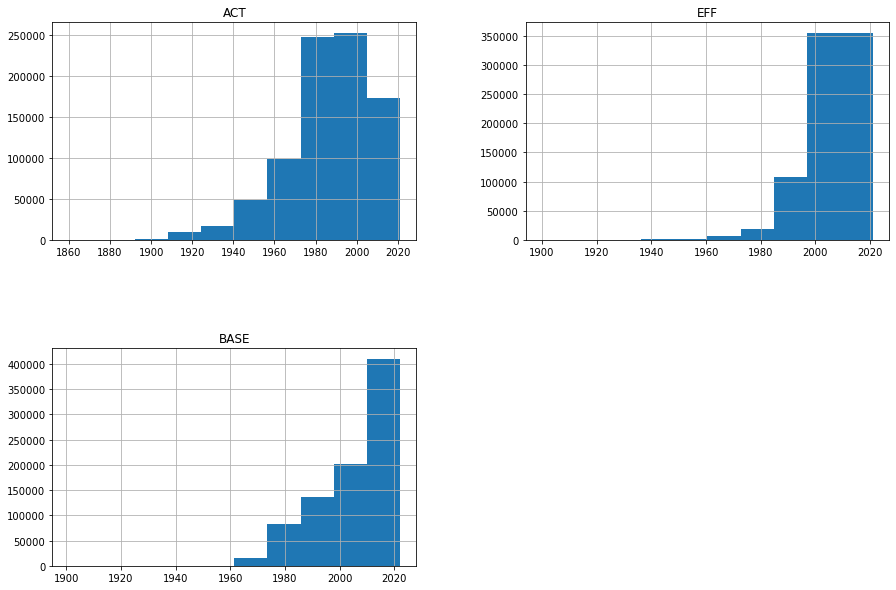

In [90]:
sales_df[['ACT', 'EFF', 'BASE']].astype(int).hist(figsize=(15,10))
plt.ticklabel_format(useOffset=False, style='plain', axis='both')
plt.subplots_adjust(hspace=0.5);

# 23 Final DataFrame<a id='23'></a>

In [91]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 847102 entries, 8 to 2047227
Data columns (total 39 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   FOLIO            847102 non-null  object        
 1   DOR_CODE         847102 non-null  object        
 2   S_DATE           847102 non-null  datetime64[ns]
 3   VI               847102 non-null  object        
 4   QU               847102 non-null  object        
 5   REA_CD           847102 non-null  object        
 6   S_AMT            847102 non-null  float64       
 7   S_TYPE           847102 non-null  object        
 8   ORIG_SALES_DATE  847102 non-null  datetime64[ns]
 9   SITE_ADDR        847013 non-null  object        
 10  SITE_CITY        847095 non-null  object        
 11  SITE_ZIP         847102 non-null  object        
 12  tBEDS            847102 non-null  float64       
 13  tBATHS           847102 non-null  float64       
 14  tSTORIES         84

In [92]:
sales_df.head().T

,8,9,11,14,20
FOLIO,0000080100,0000080100,0000090100,0000090100,0000100000
DOR_CODE,0100,0100,0100,0100,0100
S_DATE,1987-08-01 00:00:00,1985-11-01 00:00:00,2021-10-27 00:00:00,1997-05-01 00:00:00,1988-06-01 00:00:00
VI,I,V,I,I,I
QU,Q,Q,Q,Q,Q
REA_CD,01,01,01,01,01
S_AMT,50000.0,24000.0,750000.0,169900.0,52500.0
S_TYPE,WD,WD,WD,WD,WD
ORIG_SALES_DATE,1985-11-01 00:00:00,1985-11-01 00:00:00,1973-01-01 00:00:00,1973-01-01 00:00:00,1977-12-01 00:00:00
SITE_ADDR,19859 ANGEL LN,19859 ANGEL LN,19913 ANGEL LN,19913 ANGEL LN,6934 W COUNTY LINE RD


In [93]:
print(sales_df.isna().sum())

FOLIO               0
DOR_CODE            0
S_DATE              0
VI                  0
QU                  0
REA_CD              0
S_AMT               0
S_TYPE              0
ORIG_SALES_DATE     0
SITE_ADDR          89
SITE_CITY           7
SITE_ZIP            0
tBEDS               0
tBATHS              0
tSTORIES            0
tUNITS              0
tBLDGS              0
JUST                0
LAND                0
BLDG                0
EXF                 0
ACT                 0
EFF                 0
HEAT_AR             0
ASD_VAL             0
TAX_VAL             0
SD1                 0
SD2                 0
TIF                 0
BASE                0
ACREAGE             0
NBHC                0
MUNICIPALITY_CD     0
SECTION_CD          0
TOWNSHIP_CD         0
RANGE_CD            0
LAND_TYPE_ID        0
BLOCK_NUM           0
LOT_NUM             0
dtype: int64


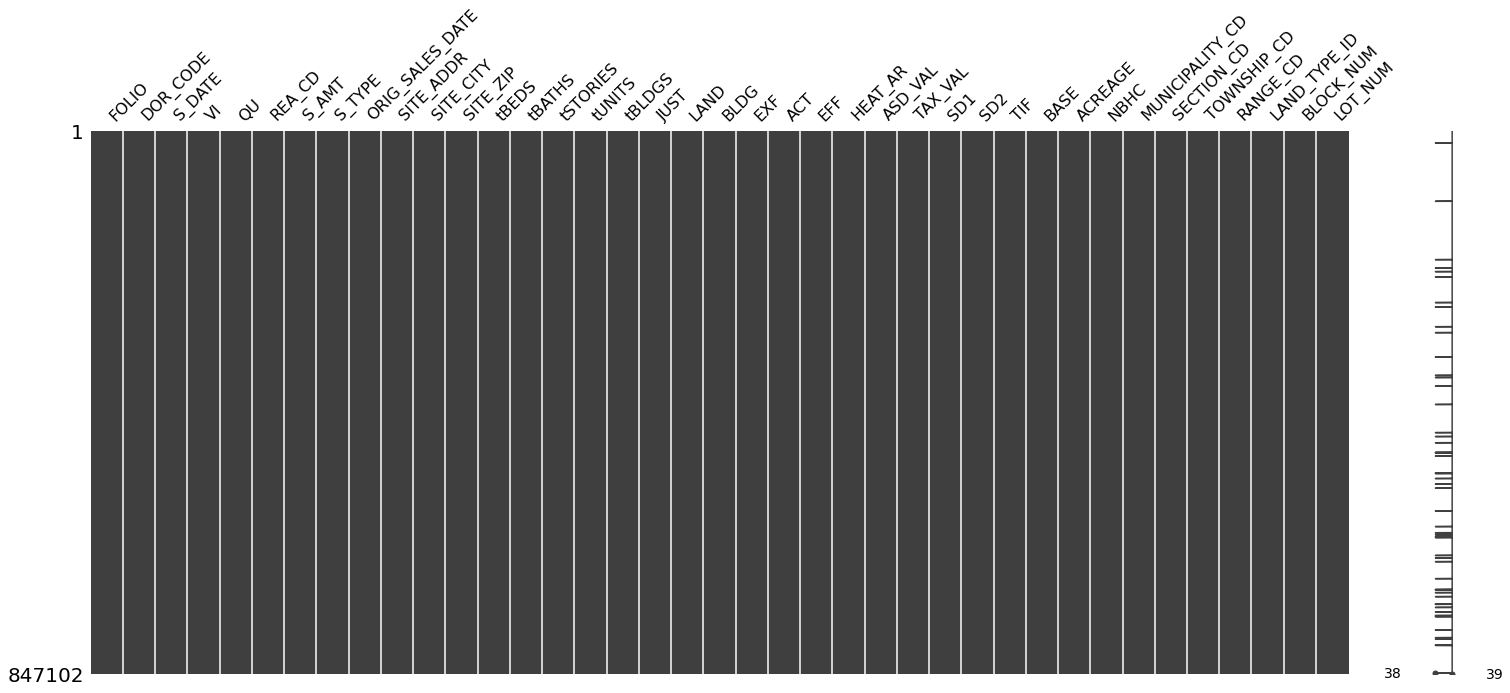

In [94]:
# Visualize missingness matrix
msno.matrix(sales_df)
plt.show()

In [95]:
# Save sales_df to interim data folder as csv file
sales_df.to_csv(interim_data + 'sales_df.csv', index=False)

In [96]:
sales_profile_report = sales_df.profile_report(explorative=True, html={'style': {'full_width': True}})
sales_profile_report.to_file(report_figures + "sales_wrangled_profile.html")

Summarize dataset:   0%|          | 0/54 [00:00<?, ?it/s]

C:\Users\mkars\anaconda3\lib\site-packages\scipy\stats\stats.py:4812: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]